In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
from typing import Callable
from functools import partial

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor

# Perceptron

I tried this for a while without a bias, and was unable to get convergence. I think this is because, while the data is linearly seperable, it is not linearly separable with a line cenetered at the origin.

In [2]:
x1 = [0.4, 0.1, 0.3, 0.6, 0.7, 0.9, 1.0, 0.2, 0.8, 0.25, 0.45, 0.78]
x2 = [0.2, 0.9, 0.4, 0.2, 0.8, 0.3, 0.5, 1.0, 0.5, 0.5, 0.13, 0.95]
y_train =  [-1, -1, -1, -1, 1, 1, 1, -1, 1]

x1_train = x1[:-3]
x2_train = x2[:-3]
w = np.zeros(2)
w0 = 0

converged = False
while not converged: # could be dangerous in practice, but fine for the toy example.
    converged = True
    for row, yval in zip(zip(x1_train, x2_train), y_train):
        predict = ((sum(w * row) + w0) > 0) * 2 - 1
        error = (predict - yval) / 2
        if error:
            converged = False
        w = w - (error * np.array(row))
        w0 = w0 - (error)

final = pd.DataFrame(data={'x1': x1, 'x2': x2})
final['y'] = ((final * w).sum(axis=1) + w0 > 0) * 2 - 1

In [3]:
def color_result(row):
    return ['background-color: yellow' if row.name >=9 else '' for _ in row]

In [4]:
final.style.apply(color_result, axis=1)

,x1,x2,y
0,0.400000,0.200000,-1
1,0.100000,0.900000,-1
2,0.300000,0.400000,-1
3,0.600000,0.200000,-1
4,0.700000,0.800000,1
5,0.900000,0.300000,1
6,1.000000,0.500000,1
7,0.200000,1.000000,-1
8,0.800000,0.500000,1
9,0.250000,0.500000,-1


# Logistic Regression

In [5]:
rawdata = pd.read_csv('winequality-red-train.csv', index_col=0)
rawdata.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
2,7.8,0.88,NaN,2.6,0.098,25.0,67,0.9968,3.20,0.68,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60,0.9980,3.16,0.58,9.8,6
6,7.4,0.66,NaN,1.8,0.075,13.0,40,0.9978,3.51,0.56,9.4,5
7,7.9,0.60,0.06,1.6,0.069,15.0,59,0.9964,3.30,0.46,9.4,5
8,7.3,0.65,NaN,1.2,0.065,15.0,21,0.9946,3.39,0.47,10.0,7


### 1 EDA

#### a) Determine features having missing values. If so, do the imputation with 0, average, and median. Observe how the imputation changes the distribution of the features. Pick one for the analysis. Explain a reason of your pick.

In [6]:
rawdata.isna().sum()

fixed.acidity             0
volatile.acidity          0
citric.acid             106
residual.sugar            0
chlorides                 0
free.sulfur.dioxide       0
total.sulfur.dioxide      0
density                   0
pH                        0
sulphates                 0
alcohol                   0
quality                   0
dtype: int64

Only the citric acid column contains NA values. Lets look at the distribution of this variable. Here, I plot the original distribution on top of the imputed distribution, so we can see the difference. 

       citric.acid
count   827.000000
mean      0.305091
std       0.184566
min       0.010000
25%       0.150000
50%       0.300000
75%       0.450000
max       1.000000
med       0.300000


Text(0.5, 1.0, 'imputed with median, mean=0.31, median=0.26')

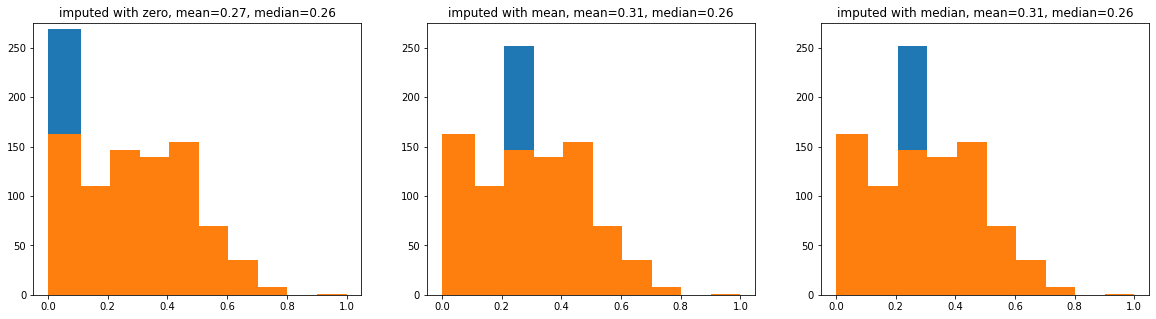

In [7]:
imp_zero = rawdata['citric.acid'].copy().fillna(0)
imp_mean = rawdata['citric.acid'].copy().fillna(rawdata['citric.acid'].mean())
imp_median = rawdata['citric.acid'].copy().fillna(rawdata['citric.acid'].median())


pprint(rawdata[['citric.acid']].describe())
print(f'{"med".ljust(10)}{rawdata["citric.acid"].median():.6f}')

fix, ax = plt.subplots(1, 3, figsize=(20,5))

bins = np.histogram(rawdata.loc[rawdata['citric.acid'].notnull(), 'citric.acid'])[1].tolist()
bins[0] = 0

ax[0].hist(imp_zero, bins=bins);
ax[0].hist(rawdata['citric.acid'], bins=bins);
ax[0].set_ylim(0, 275)
ax[0].set_title(f'imputed with zero, mean={imp_zero.mean():.2f}, median={imp_zero.median():.2f}')

ax[1].hist(imp_mean, bins=bins);
ax[1].hist(rawdata['citric.acid'], bins=bins);
ax[1].set_ylim(0, 275)
ax[1].set_title(f'imputed with mean, mean={imp_mean.mean():.2f}, median={imp_zero.median():.2f}')

ax[2].hist(imp_median, bins=bins);
ax[2].hist(rawdata['citric.acid'], bins=bins);
ax[2].set_ylim(0, 275)
ax[2].set_title(f'imputed with median, mean={imp_mean.mean():.2f}, median={imp_zero.median():.2f}')

In this scenario, the mean and meadian are almost exactly the same, so picking one or the other does not matter much. If there were a lot of outliers, or large outliers, we would probably go with the median. Both look better than imputing with zero, to me, as the imputation of zero appears to shift the distribution quite a bit. This can be seen, as it drops the mean of column down 0.27.

In [8]:
rawdata['citric.acid'] = rawdata['citric.acid'].fillna(rawdata['citric.acid'].mean())

#### b) Investigate any interesting or noticeable characteristics of features by ‘quality’. 

We will look at this first by correlation.

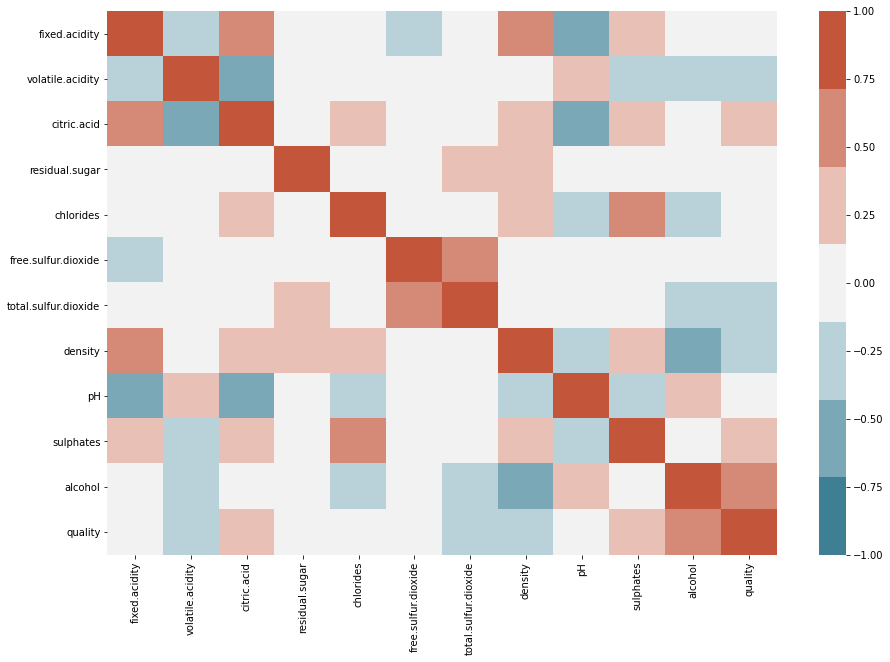

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.heatmap(rawdata.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(220, 20, n=7))

Interestingly enough, most of the features are not correlated with quality. That's not to say there is not information in those features, but that those features do not *directly* relate to our quality. We do see a decently strong positive correlation between the alcohol level and the quality of the wine. Additionally, more sulphites and lower total sulpher dioxide both imply a higher quality wine (which almost seems contradictory).

As an aside, citric acid appears correlated to several other acidity features. Perhaps we could have used that to better impute our values...

Plotting alcohol against quality on scatter, its clear that this relationship is not enough alone to make predictions on quality, but certainly its an indicator. The box echos this as well.

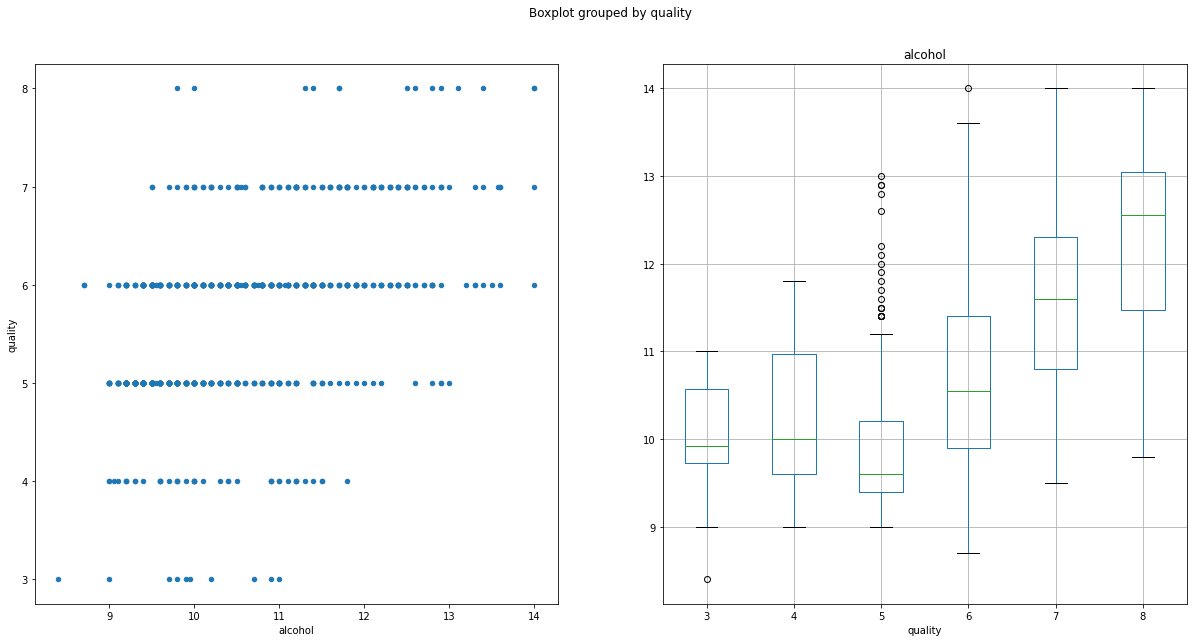

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

rawdata.plot(x='alcohol', y='quality', kind='scatter', ax=ax[0])
rawdata.boxplot(column='alcohol', by='quality', ax=ax[1])

It might also be worth just noting how 'quality' is distributed. Are any classes over/under represented?

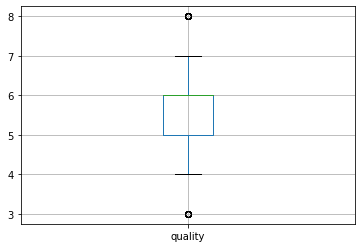

In [11]:
rawdata.boxplot(column='quality')

From this, it looks like we don't much much quality from either 3 or 8, so we may not be great at modeling those classes.

In [12]:
rawdata.quality.value_counts()

5    388
6    367
7    112
4     42
8     14
3     10
Name: quality, dtype: int64

#### c) The target, ‘quality’, is formed in integers from 3 to 8. We want to a binary classifier problem. How are you going to make this a binary classification problem? 

For this, I am goign to make six different classifiers, where each classifier is one vs the rest. Then, we could take a max of the most likely prediciton.  
  
A second approach (not implemented) would take into account the ordered nature of the classes. We could have multiple classifiers, where each classifier gave a zero or one value to bucketize the wine, where each classifier had different bucket. The classifiers could then 'vote' to find which class was most likely.

## 2) Build the Logistic Regression model.

Initializing the weight and bias:

In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(rawdata[rawdata.columns[:-1]])
y_train = pd.get_dummies(rawdata['quality'])  # one col per quality level

raw_test_data = pd.read_csv('winequality-red-test.csv', index_col=0)
raw_test_data.isna().sum()

X_test = scaler.transform(raw_test_data[raw_test_data.columns[:-1]])
y_test = raw_test_data['quality']

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def get_loss(y, z):
    losses = -y * np.log(sigmoid(z)) - (1 - y) * np.log(1 - sigmoid(z))
    return sum(losses)


def loss_gradient(y, z, X):
    return np.matmul((sigmoid(z) - y), X) / len(y)


class CustomLogisticRegression():
    
    def __init__(self, learning_rate: float = 0.5):
        self.weights = np.zeros(11)
        self.bias = 0 
        self.learning_rate = learning_rate
        
    def fit(self, X, y, epochs=1000):
        for epoch in range(epochs):
            z = self.get_z(X)
            self.update_weights(y, z, X)
            self.update_bias(z, y)
            
    def predict(self, X):
        z = get_z(X, self.weights, self.bias)
        return sigmoid(z) >= 0.5
    
    def get_z(self, X):
        return (self.weights * X).sum(axis=1) + self.bias
    
    def update_weights(self, y, z, X):
        self.weights = self.weights - self.learning_rate * loss_gradient(y, z, X)

    def update_bias(self, z, y):
        self.bias = self.bias - self.learning_rate * (sigmoid(z) - y).sum() / len(y)

        
class CLREnsemble():
    
    def __init__(self, n):
        self.models = [CustomLogisticRegression() for _ in range(n)]
        self.classes = [3, 4, 5, 6, 7, 8]
        
    def predict_class(self, X):
        z_arrays = {winequal: model.get_z(X) for model, winequal in zip(self.models, self.classes)}
        df = pd.DataFrame(z_arrays)
        return df.idxmax(axis=1).tolist()

In [15]:
ensemble = CLREnsemble(6)

for model, column_name in zip(ensemble.models, y_train.columns):
    column = y_train[column_name]
    model.fit(X_train, column, epochs=100)

In [16]:
predict = ensemble.predict_class(X_test)

In [17]:
mse = mean_squared_error(raw_test_data['quality'], predict)
mae = mean_absolute_error(raw_test_data['quality'], predict)
f1 = f1_score(raw_test_data['quality'], predict, average='weighted')
print(f'Custom LR MAE: {mae}')
print(f'Custom LR MSE: {mse}')
print(f'Custom LR F1: {f1}')

Custom LR MAE: 0.4520547945205479
Custom LR MSE: 0.5068493150684932
Custom LR F1: 0.5342529921481067


## 3) Sklearn Logistic Regression

In [18]:
scaler = StandardScaler()

X_train = scaler.fit_transform(rawdata[rawdata.columns[:-1]])
y_train = rawdata['quality']  # one col per quality level

X_test = scaler.transform(raw_test_data[raw_test_data.columns[:-1]])
y_test = raw_test_data['quality']

It looks like sklearn uses 'C', which appears to be the reciprocal of lambda.

In [19]:
lambdas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
lr_models = [LogisticRegression(C=1/lamb, solver='newton-cg', multi_class='ovr') for lamb in lambdas]

k = 10

for lamb, model in zip(lambdas, lr_models):
    scores = cross_val_score(model, X_train, y_train, cv=k)
    summed = sum(scores)
    mean = summed / k
    print(f'lambda {lamb:.6f} model mean CV score: {mean}')

lambda 0.000100 model mean CV score: 0.5616906886296043
lambda 0.001000 model mean CV score: 0.5616906886296043
lambda 0.010000 model mean CV score: 0.5616906886296043
lambda 0.100000 model mean CV score: 0.5606154198123999
lambda 1.000000 model mean CV score: 0.5584648821779913
lambda 10.000000 model mean CV score: 0.5584305650880805
lambda 100.000000 model mean CV score: 0.547746511095859
lambda 1000.000000 model mean CV score: 0.5328071379547014


Here, lambda=1 has the best score of the lot. This is the model I will choose moving forward.

## 4) Sklearn Logistic Regression Test

Now, we can test our model on the test set.

In [20]:
final_lr_model = lr_models[4]
final_lr_model.fit(X_train, y_train)
predict = final_lr_model.predict(X_test)

In [21]:
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
f1 = f1_score(y_test, predict, average='weighted')
print(f'Sklearn LR MAE: {mae}')
print(f'Sklearn LR MSE: {mse}')
print(f'Sklearn LR F1: {f1}')

Sklearn LR MAE: 0.4452054794520548
Sklearn LR MSE: 0.5
Sklearn LR F1: 0.5473375009018148


Overall, our model appears to be doing quite well. In fact, these numbers are very, very close to my own custom version of the logistic regression model.

# SVM

### What is the equation of the SVM hyperplane ℎ(x)? Draw the hyperplane with the 10 points. 

In [22]:
xi1 = [4.0, 4.0, 1.0, 2.5, 4.9, 1.9, 3.5, 0.5, 2.0, 4.5]
xi2 = [2.9, 4.0, 2.5, 1.0, 4.5, 1.9, 4.0, 1.5, 2.1, 2.5]
X_svm = pd.DataFrame({'x1': xi1, 'x2': xi2})
y_svm  = [1, 1, -1, -1, 1, -1, 1, -1, -1, 1]
alphai = [0.414, 0.0, 0.0, 0.018, 0.0, 0.0, 0.018, 0.0, 0.414, 0.0]

As we already know a, we can calculate w the sum of all a_i * y_i * x_i. Then we know that any of the support vectors (where alpha !=0) dotted with the weights, multiplied by y, and added to the bias gives us 1. We use this formula to calculate our intercept.

In [23]:
w = X_svm.multiply(np.multiply(alphai, y_svm), axis=0).sum()

w_l2 = np.sqrt((w**2).sum())
m = 2 / w_l2

b = 1 - np.dot(w, X_svm.iloc[0])

We know the following equation:  

w[0]*x1 + w[1]*x2 + b = 0  

We can try to rewrite this as x2 being a function of x1:  

w[0]*x1 + b = -w[1]*x2  
w[0] / -w[1] * x1 + b / -w[1] = x2

so, our slope = w[0] / -w[1]
and intercept = b / -w[1]

(0.0, 6.0)

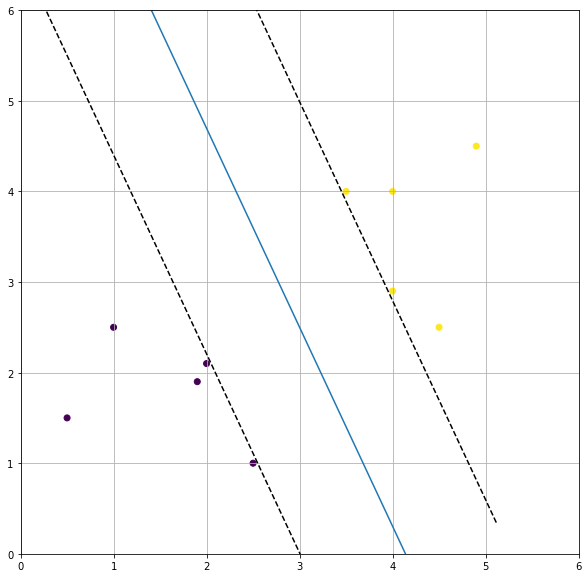

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.scatter(xi1, xi2, c=y_svm)

slope = w[0] / -w[1]
intercept = b / -w[1]

intercept_dist = m / w_l2**2
# alternatively, we could recalculate our m using one of the support vectors provided.

x_line = np.linspace(*ax.get_xlim(), 20)
y_line_0 = x_line * slope + intercept  # hyperplane decision boundary
y_line_1 = x_line * slope + intercept - intercept_dist
y_line_2 = x_line * slope + intercept + intercept_dist
plt.plot(x_line, y_line_0, '-', x_line, y_line_1, '--k', x_line, y_line_2, '--k')

ax.grid()
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

### What is the distance of x6 from the hyperplane? Is this within the margin of the classifier?

This can be calucated geometrically. From above, we have a line of the form:  

Ax + By + C = 0   

Here,  

A = w[0] = 0.846  
B = w[1] = 0.3852  
C =  b   = -3.50108

In [25]:
numer = abs(w[0] * xi1[5] + w[1] * xi2[5] + b)

dist = numer / w_l2

In [26]:
print(f'Distance between x9 and hyperplane: {dist}')
print(f'Distance to be within margins: {m/2}')

Distance between x9 and hyperplane: 1.2498290534100407
Distance to be within margins: 1.075769541582063


As we can see, x6 is outside of our hyperplane margins (as expected).

###  Classify the point z = (3,3)T using ℎ(x) from above. 

To classify this point, we simply plug it in to our formula above, and check the sign of the output.

In [27]:
raw_class = np.dot((3,3), w) + b
print(raw_class)

0.19252000000000002


Beause this value is greater than zero, we would classify this point as y=1.

# Gaussian Process

## 1) Implement Gaussian process regression for univariate variables y and x

f(x) ~ GP(m(x), k(x, x'))  

m(x) == mean function == 0 for our case
k(x, x') == covariance function

In [28]:
def squared_exponential_kernel(x, x_p, lambda_):   # From demonstration
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(x_p**2, 1) - 2*np.dot(x, x_p.T)
    return np.exp(-.5 * (1/lambda_) * sqdist)


#   expanded quadratic?
#   (X - X_P) ** 2 =
#   X**2 - 2 * X * X_P + X_P ** 2

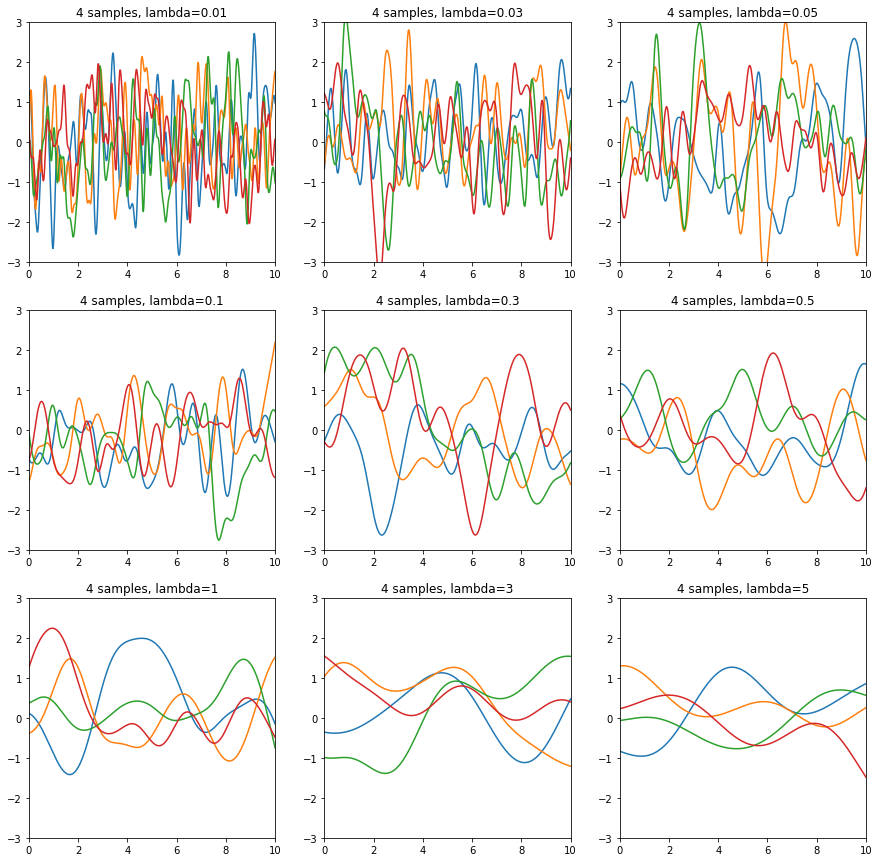

In [29]:
num_samples = 4
length = 1000
start = 0
end = 10

x = np.linspace(start, end, length).reshape(-1,1)    

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
lambdas = (0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3, 5)

for lamb, ax in zip(lambdas, axes.reshape(-1)):
    K_ss = squared_exponential_kernel(x, x, lambda_=lamb) + 1e-15 * np.eye(length)

    L = np.linalg.cholesky(K_ss + 1e-10 * np.eye(length))  
    # this is where we are adding a small value to ensure this is invertable. Cholesky allows us to invert easier.     
    
    f_prior = np.dot(L, np.random.normal(size=(length, num_samples)))  
    # (num_samples x length samples) from the standard normal for the test points, dotted with our covariance matrix 
    
    ax.plot(x, f_prior)
    ax.axis([start, end, -3, 3])
    ax.set_title(f'{num_samples} samples, lambda={lamb}')
 

Here, it is obvious that lambda is effecting how 'noisy' the prior functions are. A better take on this, is the periodicity of the prior functions with smaller lambdas is much, much higher. While in the next problem (part 2) I mention overfitting and underfitting, it is clear from this that the correct value of lambda is not necessarily just a balance between overfitting and underfitting, but also should be selected on the actual data at hand. That is, functions that have lower periodicity would be better served with a higher lambda, all other things held constant (and vis versa). 

## 2) Testing and Plotting the Gaussian Process

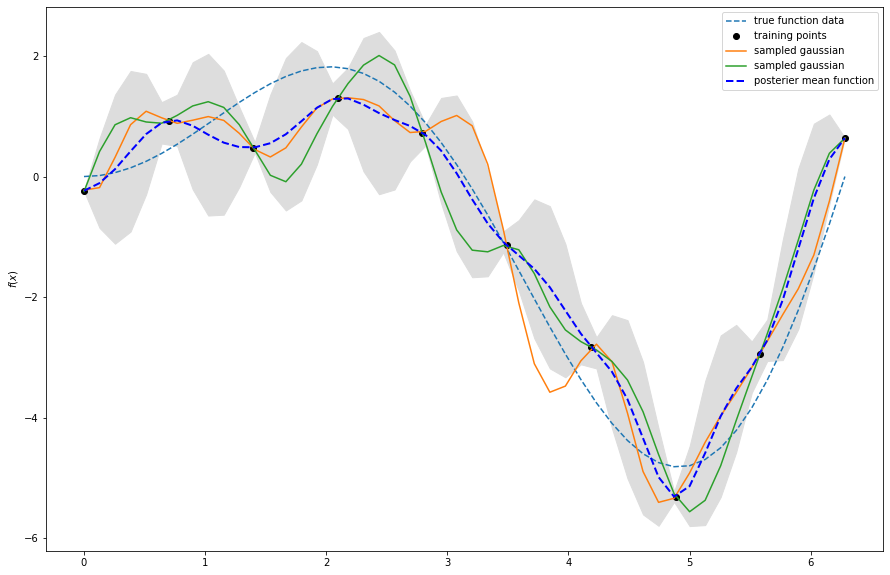

In [36]:
lambda_ = 0.1

# Noise Free Training Data
n_train = 10
# X_train = np.random.uniform(0, 2*np.pi, size=n_train).reshape(-1, 1)
X_train = np.linspace(0, 2*np.pi, n_train).reshape(-1, 1)
train_noise = np.random.normal(scale=0.5, size=n_train).reshape(-1, 1)
y_train = X_train * np.sin(X_train) + train_noise

n_test = 50
X_test = np.linspace(0, 2*np.pi, n_test).reshape(-1, 1)
y_true = X_test * np.sin(X_test)

K = squared_exponential_kernel(X_train, X_train, lambda_=lambda_)
L = np.linalg.cholesky(K + 5e-10*np.eye(len(X_train)))

K_s = squared_exponential_kernel(X_train, X_test, lambda_=lambda_)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, y_train)).reshape(n_test,)

K_ss = squared_exponential_kernel(X_test, X_test, lambda_) + 1e-5 * np.eye(len(X_test))
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points.
num_gaussians = 2
L = np.linalg.cholesky(K_ss + 5e-5*np.eye(n_test) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_test, num_gaussians)))


fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.plot(X_test, y_true, '--', label='true function data')
plt.plot(X_train, y_train, 'ok', label='training points')
plt.plot(X_test, f_post, label='sampled gaussian')

ax.fill_between(X_test.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")  # two standard deviations is our confidence interval

plt.plot(X_test, mu, 'b--', lw=2, label='posterier mean function')
plt.legend(loc='upper right')
plt.ylabel('$f(x)$')
plt.show()

Here, we can see that the confidence interval does a good job encompassing our true function, despite the fact that our observations were quite noisy. We also have found a good value of lambda, where the larger values of lambda were appearing to cause the model to significantly overfit. That is, very high bias with low variance. This model has lower bias and higher variance, but is objectively a significantly better model.